In [13]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from filterbank.components import Resonator,TransmissionLine,DirectionalFilter,ReflectorFilter,ManifoldFilter,Filterbank,BaseFilter


# mpl.rcParams.update(mpl.rcParamsDefault)

# Font sizes for plot
mpl.rcParams['font.size'] = 11
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['figure.titlesize'] = 12

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.minor.width'] = 0.4
mpl.rcParams['xtick.major.width'] = 0.6
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.minor.width'] = 0.4
mpl.rcParams['ytick.major.width'] = 0.6

mpl.rcParams['axes.linewidth'] = 0.6
mpl.rcParams['lines.linewidth'] = 0.75
mpl.rcParams['lines.markersize'] = 0.75
mpl.rcParams['figure.figsize'] = [2.5,2.5]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["savefig.dpi"] = 400

%matplotlib inline

fig_path = "./figures/"

Filtertype_color_dict = {
    'ManifoldFilter' : np.array([86,199,74])/255,
    'ReflectorFilter' : np.array([242,131,45])/255,
    'DirectionalFilter' : np.array([90,136,237])/255
}

In [14]:
nF = int(2e4)
f = np.linspace(210e9,450e9,nF)

nF = int(5e2)
f2 = np.linspace(345e9,355e9,nF)

f0_min = 220e9
f0_max = 440e9


R_spacings = np.arange(300,700,100,dtype=int)
R_filter_widths = np.arange(300,700,100,dtype=int)
n_R_spacings = len(R_spacings)
n_R_filter_widths = len(R_filter_widths)


## Variances
sigma_Ql = 0.2
sigma_f0 = 0.085


Z0_res = 80
eps_eff_res = 40
Qi_res = np.inf


Z0_thru = 80
eps_eff_thru = 40

TL_thru = TransmissionLine(Z0_thru,eps_eff_thru)

TL_res = TransmissionLine(Z0_res,eps_eff_res,Qi=Qi_res)

TransmissionLinesDict = {
    'through' : TL_thru,
    'resonator' : TL_res,
    'MKID' : TL_thru
}

Filters = (ManifoldFilter, DirectionalFilter)

In [15]:
R_sweep_data = dict()

for Filter in Filters:
    Filterbank_data = dict()
    for R_spacing in R_spacings:
        for R_filter_width in R_filter_widths:
            

            FB = Filterbank(
                FilterClass=Filter,
                TransmissionLines=TransmissionLinesDict,
                f0_min=f0_min,
                f0_max=f0_max,
                Ql=R_filter_width,
                oversampling=R_spacing/R_filter_width,
                sigma_f0=sigma_f0 * (R_filter_width / 300),
                sigma_Ql=sigma_Ql,
                compensate=False
            )

            # Caculate S-Parameters and realized values (suppress output)
            FB.S(f);
            FB.realized_parameters();

            Filterbank_data[(R_spacing,R_filter_width)] = FB
    
    R_sweep_data[Filter] = Filterbank_data

            

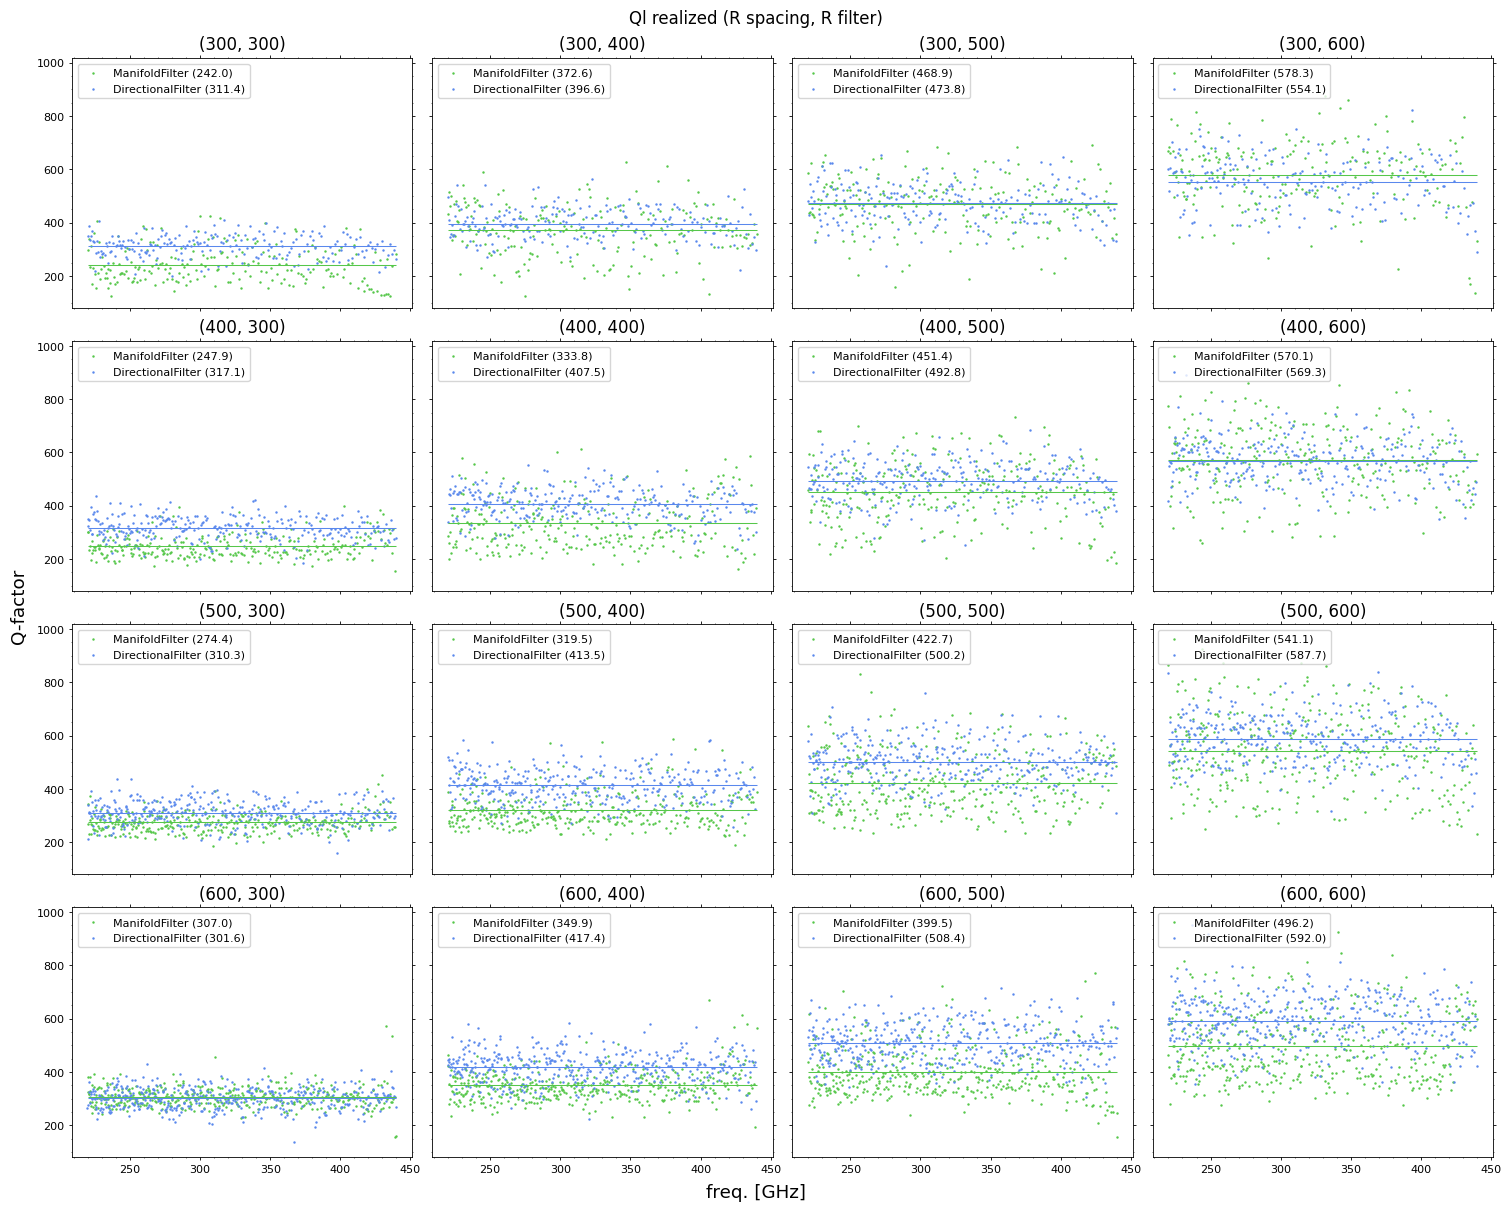

In [16]:
fig, axs = plt.subplots(nrows=n_R_spacings,ncols=n_R_filter_widths,sharex=True,sharey=True,figsize=(15,12),layout='constrained')

for row, ax_row in enumerate(axs):
    for col, ax in enumerate(ax_row):
        
        for Filter in Filters:
            filt_name = str(Filter.__name__)
            FB : Filterbank = R_sweep_data[Filter][(R_spacings[row],R_filter_widths[col])]
            ax.scatter(FB.f0_realized/1e9,FB.Ql_realized,label=f"{filt_name} ({np.mean(FB.Ql_realized):.1f})",color=Filtertype_color_dict[filt_name])
            ax.hlines(np.mean(FB.Ql_realized),FB.f0_min/1e9,FB.f0_max/1e9,color=Filtertype_color_dict[filt_name])
            ax.set_title(f"({R_spacings[row]}, {R_filter_widths[col]})")
            ax.legend(loc='upper left')


fig.supxlabel("freq. [GHz]");
fig.supylabel("Q-factor");
fig.suptitle("Ql realized (R spacing, R filter)");

In [17]:
R_comp_data = dict()
for Filter in Filters:
    Filter_R_comp_data = dict()
    for R_spacing in R_spacings:
        for R_filter_width in R_filter_widths:
            FB : Filterbank = R_sweep_data[Filter][(R_spacing,R_filter_width)]
            Filter_R_comp_data[(R_spacing, R_filter_width)] = FB.Ql / np.mean(FB.Ql_realized)
    R_comp_data[Filter] = Filter_R_comp_data

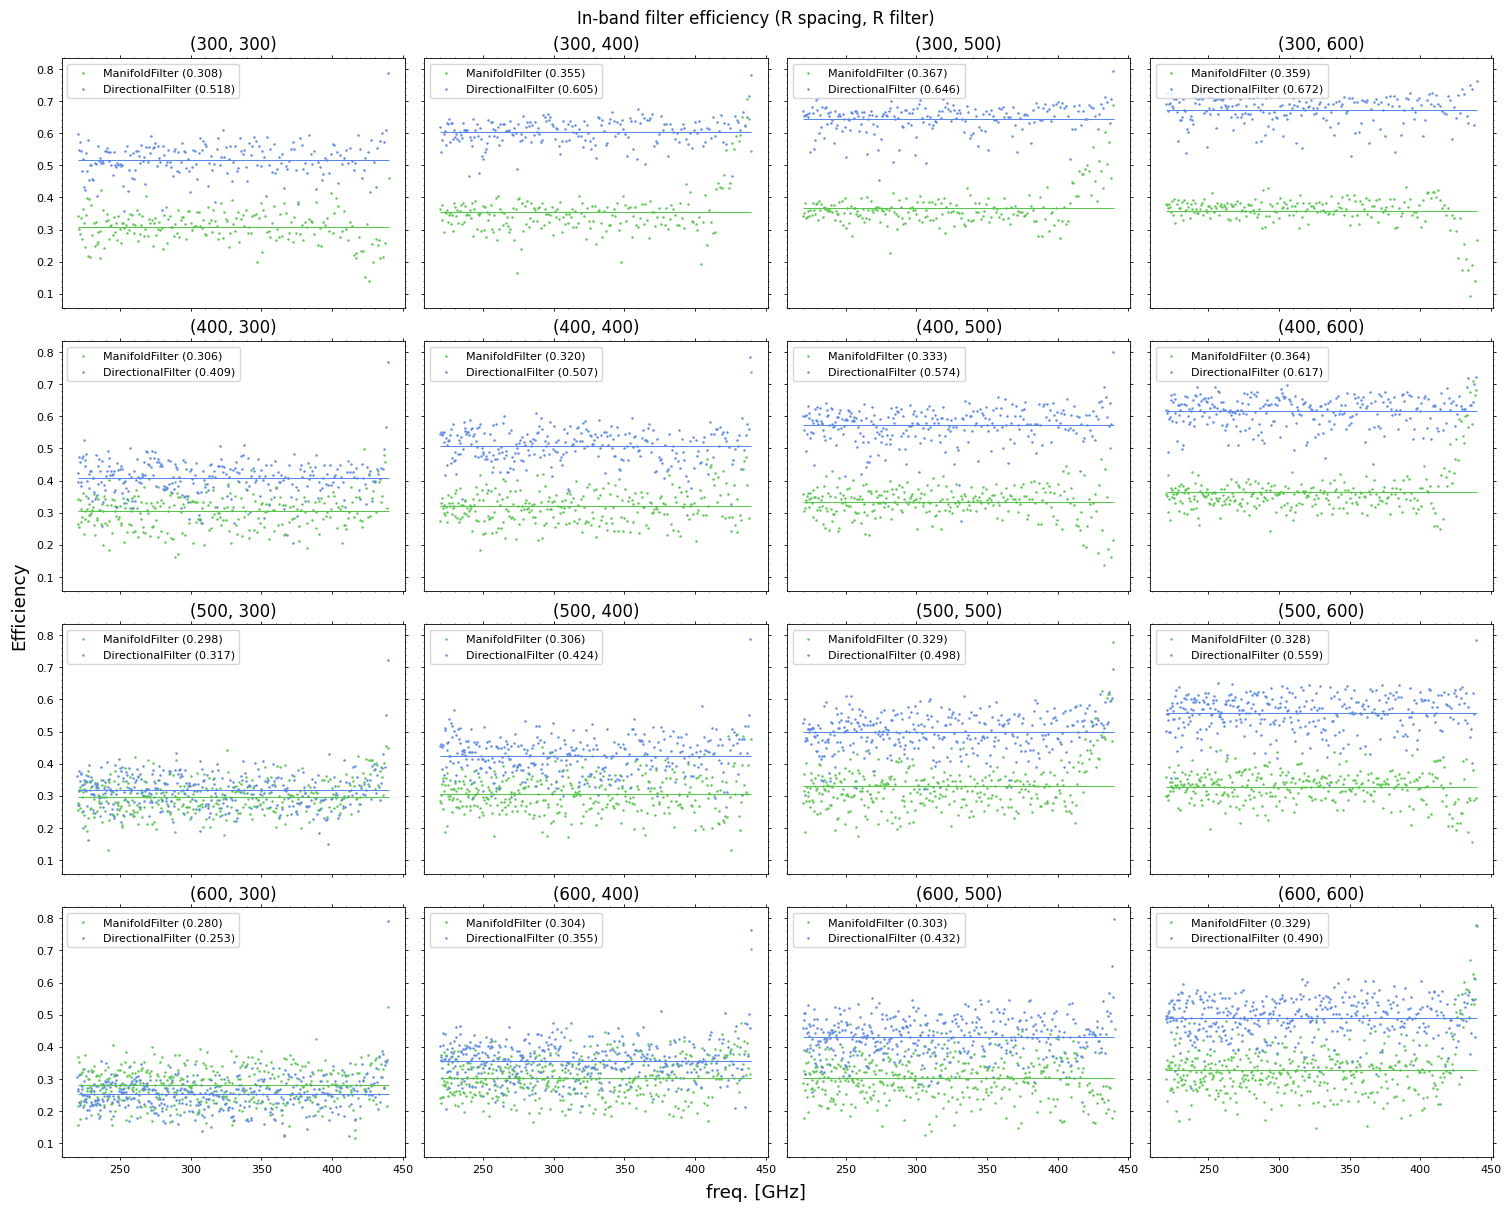

In [18]:
fig, axs = plt.subplots(nrows=n_R_spacings,ncols=n_R_filter_widths,sharex=True,sharey=True,figsize=(15,12),layout='constrained')

for row, ax_row in enumerate(axs):
    for col, ax in enumerate(ax_row):
        
        for Filter in Filters:
            filt_name = str(Filter.__name__)
            FB : Filterbank = R_sweep_data[Filter][(R_spacings[row],R_filter_widths[col])]
            ax.scatter(FB.f0_realized/1e9,FB.inband_filter_eff,label=f"{filt_name} ({np.mean(FB.inband_filter_eff):.3f})",color=Filtertype_color_dict[filt_name])
            ax.hlines(np.mean(FB.inband_filter_eff),FB.f0_min/1e9,FB.f0_max/1e9,color=Filtertype_color_dict[filt_name])
            ax.set_title(f"({R_spacings[row]}, {R_filter_widths[col]})")
            ax.legend(loc='upper left')


fig.supxlabel("freq. [GHz]");
fig.supylabel("Efficiency");
fig.suptitle("In-band filter efficiency (R spacing, R filter)");

KeyError: (20, 20)

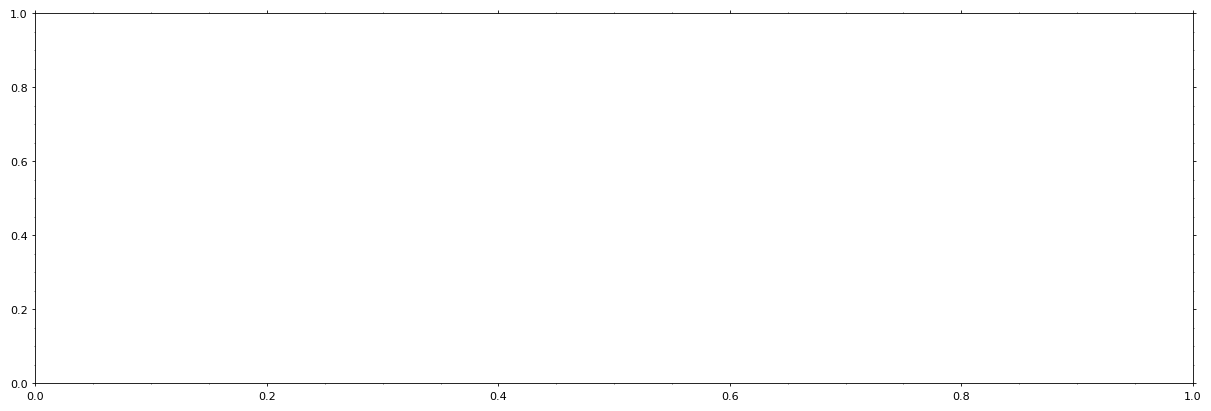

: 

In [19]:


################################################
fig, ax =plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(12,4),layout='constrained')

FB : Filterbank = R_sweep_data[ManifoldFilter][(20,20)]
S31_all = FB.S31_absSq_list

#ax
cmap = cm.get_cmap('rainbow').copy()
norm = mpl.colors.Normalize(vmin=0, vmax=np.shape(S31_all)[0])

for i,S31_absSq in enumerate(S31_all):
    ax.plot(f/1e9,100*S31_absSq,color=cmap(norm(i)))

sum_filters = np.sum(S31_all,axis=0)
ax.plot(f/1e9,100*sum_filters,label='sum filters',color="0.5")

envelope = np.array(FB.S31_absSq_list).max(axis=0)
# ax.plot(f/1e9,100*envelope["DirectionalFilter"],label='envelope',color=(0.,0.,0.))

ax.plot(f/1e9,100*FB.S11_absSq,label='S11',color=(0.,1.,1.))
ax.plot(f/1e9,100*FB.S21_absSq,label='S21',color=(1.,0.,1.))

ax.set_ylim(0,100)
ax.set_xlim(np.min(f)/1e9,np.max(f)/1e9)
ax.set_xlabel('Frequency [GHz]');
ax.set_ylabel('Transmission [%]');  # Add a y-label to the axes.
# plt.title("Realized Q-factors")  # Add a title to the axes.
# ax.legend();  # Add a legend.

# savestr = fig_path + "Filterbank_DirectionalFilter.svg"
# plt.savefig(fname=savestr)
# fig.canvas.manager.set_window_title(savestr)



In [ ]:
R_sweep_data = dict()

for Filter in Filters:
    Filterbank_data = dict()
    for R_spacing in R_spacings:
        for R_filter_width in R_filter_widths:
            
            FB = Filterbank(
                FilterClass=Filter,
                TransmissionLines=TransmissionLinesDict,
                f0_min=f0_min,
                f0_max=f0_max,
                Ql=R_filter_width * R_comp_data[Filter][(R_spacing,R_filter_width)],
                oversampling=R_spacing/(R_filter_width * R_comp_data[Filter][(R_spacing,R_filter_width)]),
                sigma_f0=sigma_f0 * (R_filter_width / 300),
                sigma_Ql=sigma_Ql,
                compensate=False
            )

            # Caculate S-Parameters and realized values (suppress output)
            FB.S(f);
            FB.realized_parameters(n_interp=5);
            # n_interp should be calculated based on filter width.

            Filterbank_data[(R_spacing,R_filter_width)] = FB
    
    R_sweep_data[Filter] = Filterbank_data


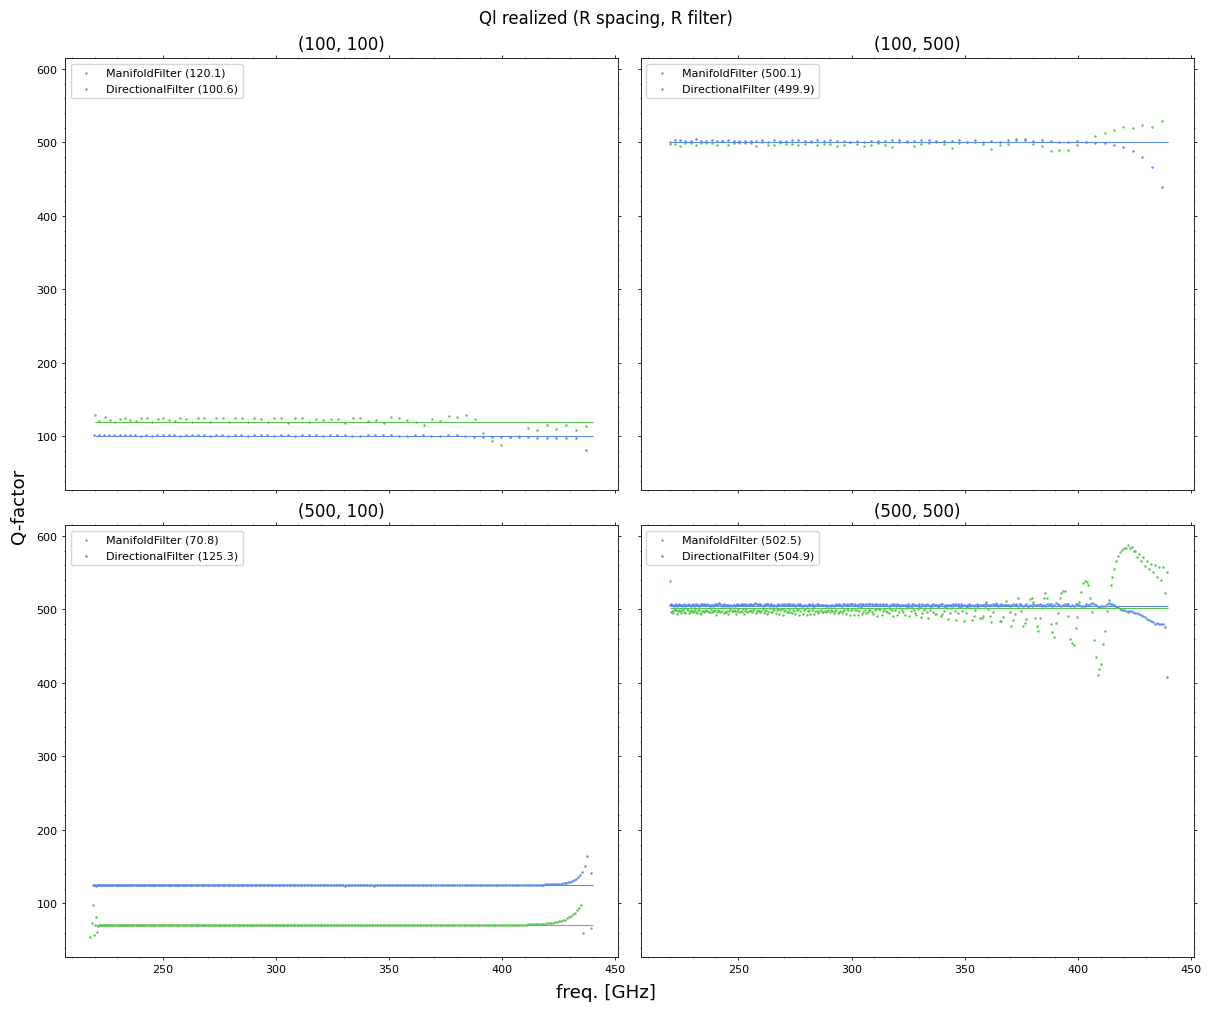

In [ ]:
fig, axs = plt.subplots(nrows=n_R_spacings,ncols=n_R_filter_widths,sharex=True,sharey=True,figsize=(12,10),layout='constrained')

for row, ax_row in enumerate(axs):
    for col, ax in enumerate(ax_row):
        
        for Filter in Filters:
            filt_name = str(Filter.__name__)
            FB : Filterbank = R_sweep_data[Filter][(R_spacings[row],R_filter_widths[col])]
            ax.scatter(FB.f0_realized/1e9,FB.Ql_realized,label=f"{filt_name} ({np.mean(FB.Ql_realized):.1f})",color=Filtertype_color_dict[filt_name])
            ax.hlines(np.mean(FB.Ql_realized),FB.f0_min/1e9,FB.f0_max/1e9,color=Filtertype_color_dict[filt_name])
            ax.set_title(f"({R_spacings[row]}, {R_filter_widths[col]})")
            ax.legend(loc='upper left')


fig.supxlabel("freq. [GHz]");
fig.supylabel("Q-factor");
fig.suptitle("Ql realized (R spacing, R filter)");

In [ ]:
R_comp_data_2 = dict()
for Filter in Filters:
    Filter_R_comp_data = dict()
    for R_spacing in R_spacings:
        for R_filter_width in R_filter_widths:
            FB : Filterbank = R_sweep_data[Filter][(R_spacing,R_filter_width)]
            Filter_R_comp_data[(R_spacing, R_filter_width)] = (R_filter_width / np.mean(FB.Ql_realized)) * R_comp_data[Filter][(R_spacing,R_filter_width)]
    R_comp_data_2[Filter] = Filter_R_comp_data


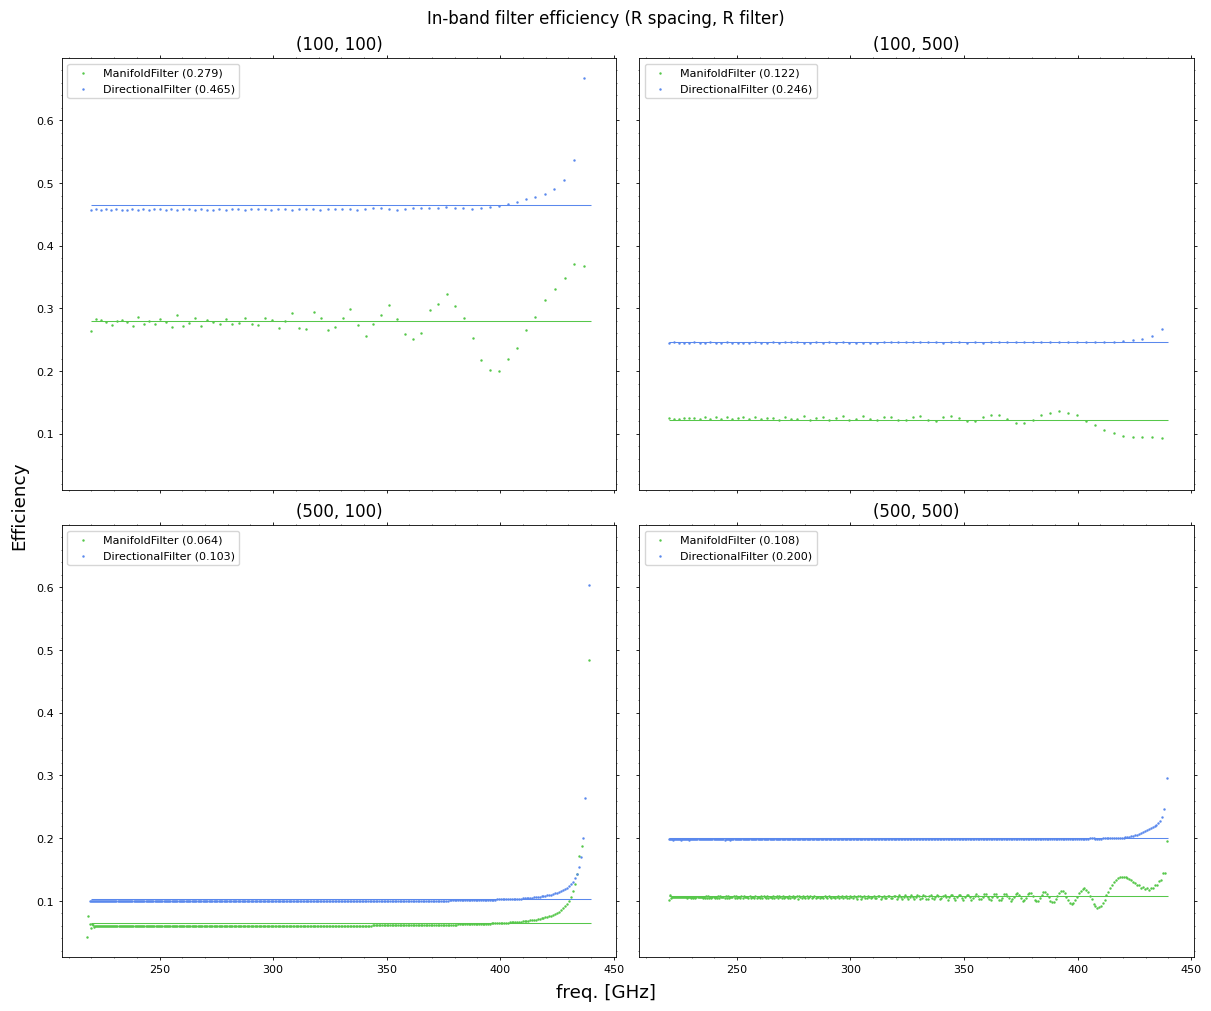

In [ ]:
fig, axs = plt.subplots(nrows=n_R_spacings,ncols=n_R_filter_widths,sharex=True,sharey=True,figsize=(12,10),layout='constrained')

for row, ax_row in enumerate(axs):
    for col, ax in enumerate(ax_row):
        
        for Filter in Filters:
            filt_name = str(Filter.__name__)
            FB : Filterbank = R_sweep_data[Filter][(R_spacings[row],R_filter_widths[col])]
            ax.scatter(FB.f0_realized/1e9,FB.inband_filter_eff,label=f"{filt_name} ({np.mean(FB.inband_filter_eff):.3f})",color=Filtertype_color_dict[filt_name])
            ax.hlines(np.mean(FB.inband_filter_eff),FB.f0_min/1e9,FB.f0_max/1e9,color=Filtertype_color_dict[filt_name])
            ax.set_title(f"({R_spacings[row]}, {R_filter_widths[col]})")
            ax.legend(loc='upper left')


fig.supxlabel("freq. [GHz]");
fig.supylabel("Efficiency");
fig.suptitle("In-band filter efficiency (R spacing, R filter)");

347
{(100, 100): 1.2720840202943209, (100, 500): 0.9871204798805242, (500, 100): 0.6791318145387708, (500, 500): 1.0255223749366296}


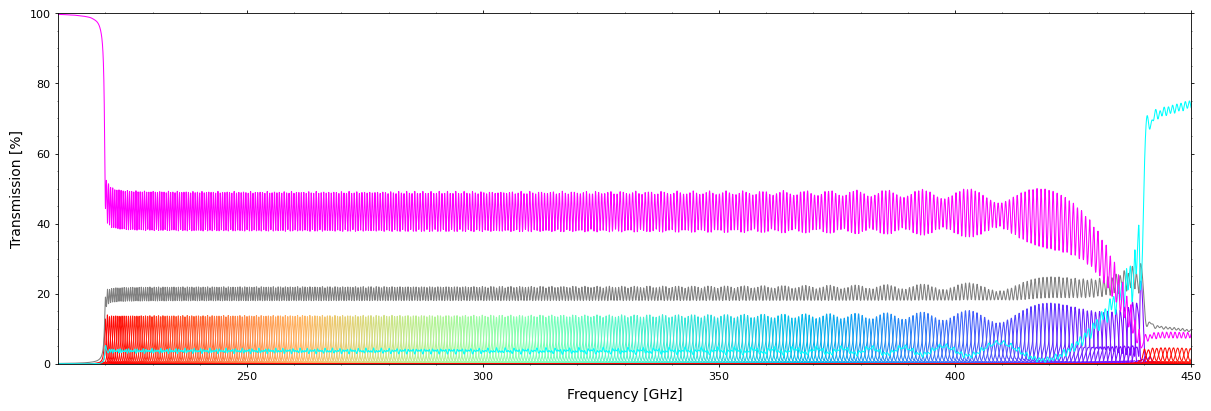

In [ ]:


################################################
fig, ax =plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(12,4),layout='constrained')

FB : Filterbank = R_sweep_data[ManifoldFilter][(500,500)]
print(FB.n_filters)
print(R_comp_data[ManifoldFilter])
S31_all = FB.S31_absSq_list

#ax
cmap = cm.get_cmap('rainbow').copy()
norm = mpl.colors.Normalize(vmin=0, vmax=np.shape(S31_all)[0])

for i,S31_absSq in enumerate(S31_all):
    ax.plot(f/1e9,100*S31_absSq,color=cmap(norm(i)))

sum_filters = np.sum(S31_all,axis=0)
ax.plot(f/1e9,100*sum_filters,label='sum filters',color="0.5")

envelope = np.array(FB.S31_absSq_list).max(axis=0)
# ax.plot(f/1e9,100*envelope["DirectionalFilter"],label='envelope',color=(0.,0.,0.))

ax.plot(f/1e9,100*FB.S11_absSq,label='S11',color=(0.,1.,1.))
ax.plot(f/1e9,100*FB.S21_absSq,label='S21',color=(1.,0.,1.))

ax.set_ylim(0,100)
ax.set_xlim(np.min(f)/1e9,np.max(f)/1e9)
ax.set_xlabel('Frequency [GHz]');
ax.set_ylabel('Transmission [%]');  # Add a y-label to the axes.
# plt.title("Realized Q-factors")  # Add a title to the axes.
# ax.legend();  # Add a legend.

# savestr = fig_path + "Filterbank_DirectionalFilter.svg"
# plt.savefig(fname=savestr)
# fig.canvas.manager.set_window_title(savestr)



In [ ]:
R_sweep_data = dict()

for Filter in Filters:
    Filterbank_data = dict()
    for R_spacing in R_spacings:
        for R_filter_width in R_filter_widths:
            
            FB = Filterbank(
                FilterClass=Filter,
                TransmissionLines=TransmissionLinesDict,
                f0_min=f0_min,
                f0_max=f0_max,
                Ql=R_filter_width * R_comp_data_2[Filter][(R_spacing,R_filter_width)],
                oversampling=R_spacing/(R_filter_width * R_comp_data_2[Filter][(R_spacing,R_filter_width)]),
                sigma_f0=sigma_f0 * (R_filter_width / 300),
                sigma_Ql=sigma_Ql,
                compensate=False
            )

            # Caculate S-Parameters and realized values (suppress output)
            FB.S(f);
            FB.realized_parameters(n_interp=5);
            # n_interp should be calculated based on filter width.

            Filterbank_data[(R_spacing,R_filter_width)] = FB
    
    R_sweep_data[Filter] = Filterbank_data


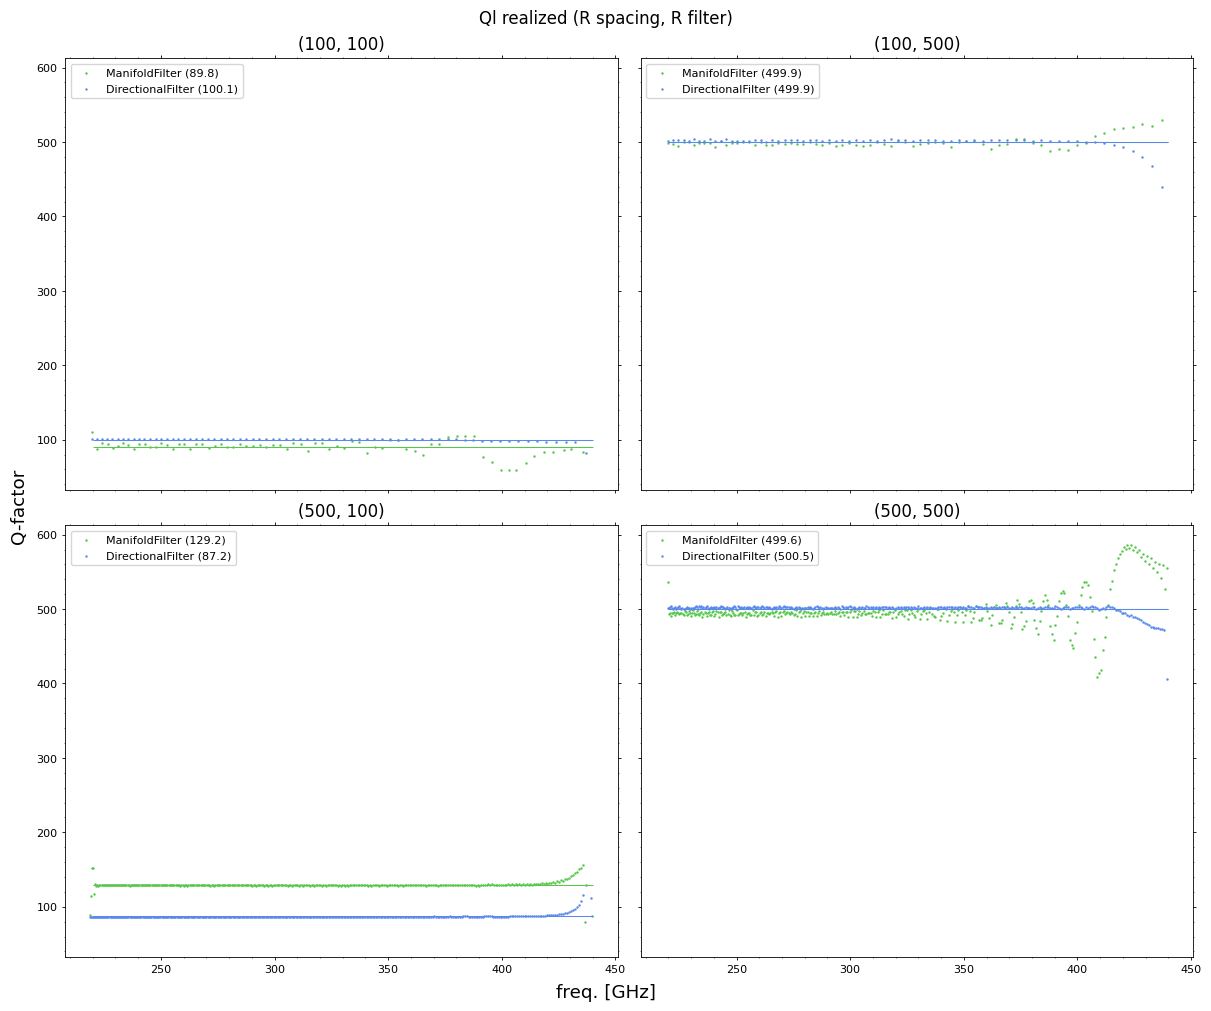

In [ ]:
fig, axs = plt.subplots(nrows=n_R_spacings,ncols=n_R_filter_widths,sharex=True,sharey=True,figsize=(12,10),layout='constrained')

for row, ax_row in enumerate(axs):
    for col, ax in enumerate(ax_row):
        
        for Filter in Filters:
            filt_name = str(Filter.__name__)
            FB : Filterbank = R_sweep_data[Filter][(R_spacings[row],R_filter_widths[col])]
            ax.scatter(FB.f0_realized/1e9,FB.Ql_realized,label=f"{filt_name} ({np.mean(FB.Ql_realized):.1f})",color=Filtertype_color_dict[filt_name])
            ax.hlines(np.mean(FB.Ql_realized),FB.f0_min/1e9,FB.f0_max/1e9,color=Filtertype_color_dict[filt_name])
            ax.set_title(f"({R_spacings[row]}, {R_filter_widths[col]})")
            ax.legend(loc='upper left')


fig.supxlabel("freq. [GHz]");
fig.supylabel("Q-factor");
fig.suptitle("Ql realized (R spacing, R filter)");

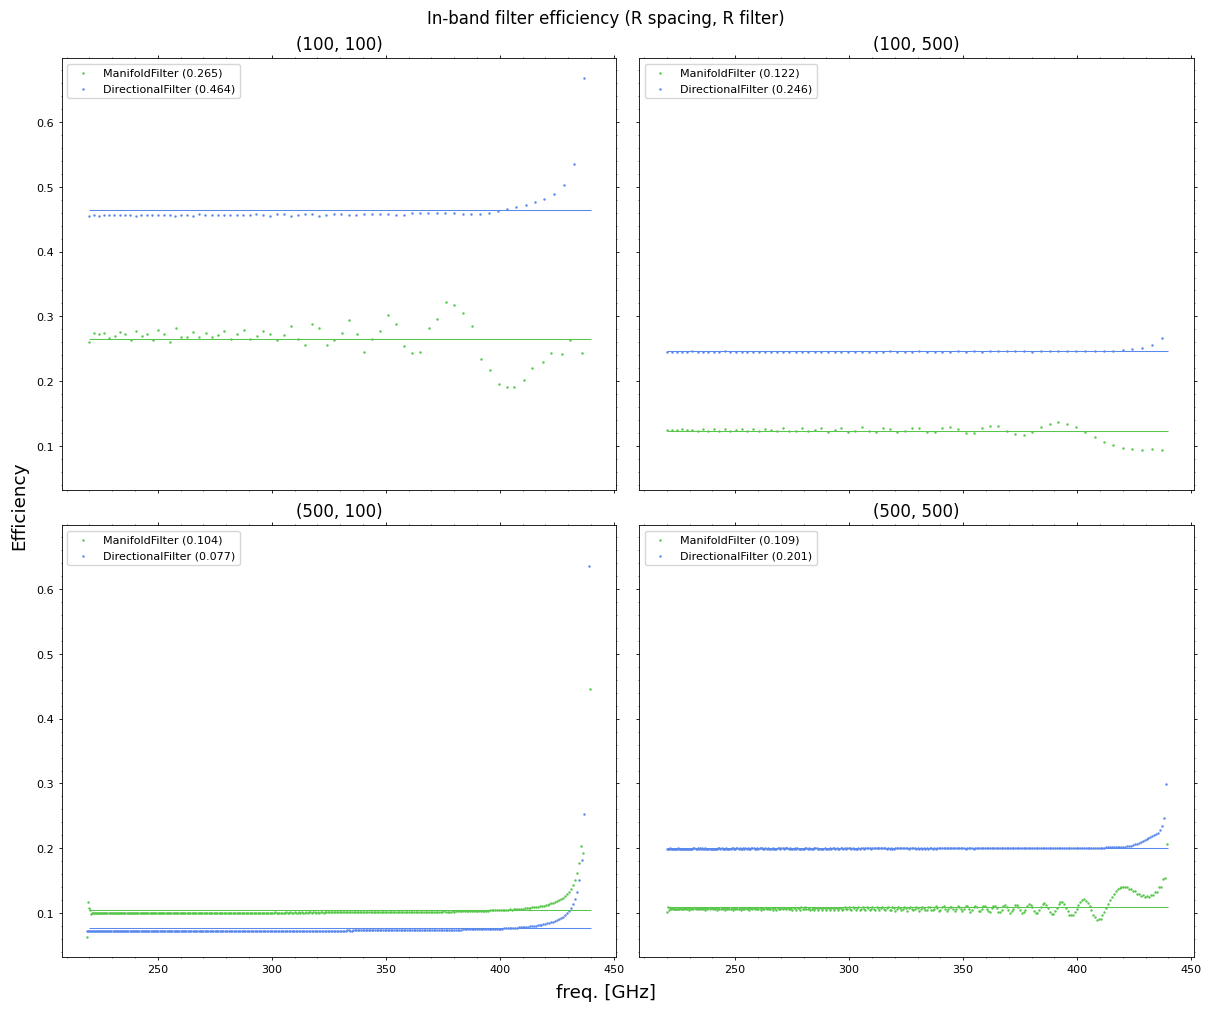

In [ ]:
fig, axs = plt.subplots(nrows=n_R_spacings,ncols=n_R_filter_widths,sharex=True,sharey=True,figsize=(12,10),layout='constrained')

for row, ax_row in enumerate(axs):
    for col, ax in enumerate(ax_row):
        
        for Filter in Filters:
            filt_name = str(Filter.__name__)
            FB : Filterbank = R_sweep_data[Filter][(R_spacings[row],R_filter_widths[col])]
            ax.scatter(FB.f0_realized/1e9,FB.inband_filter_eff,label=f"{filt_name} ({np.mean(FB.inband_filter_eff):.3f})",color=Filtertype_color_dict[filt_name])
            ax.hlines(np.mean(FB.inband_filter_eff),FB.f0_min/1e9,FB.f0_max/1e9,color=Filtertype_color_dict[filt_name])
            ax.set_title(f"({R_spacings[row]}, {R_filter_widths[col]})")
            ax.legend(loc='upper left')


fig.supxlabel("freq. [GHz]");
fig.supylabel("Efficiency");
fig.suptitle("In-band filter efficiency (R spacing, R filter)");

347
(347, 20000)
[7.27836196e-08 7.27885242e-08 7.27969161e-08 ... 3.68884491e-04
 3.81470514e-04 3.93925339e-04]


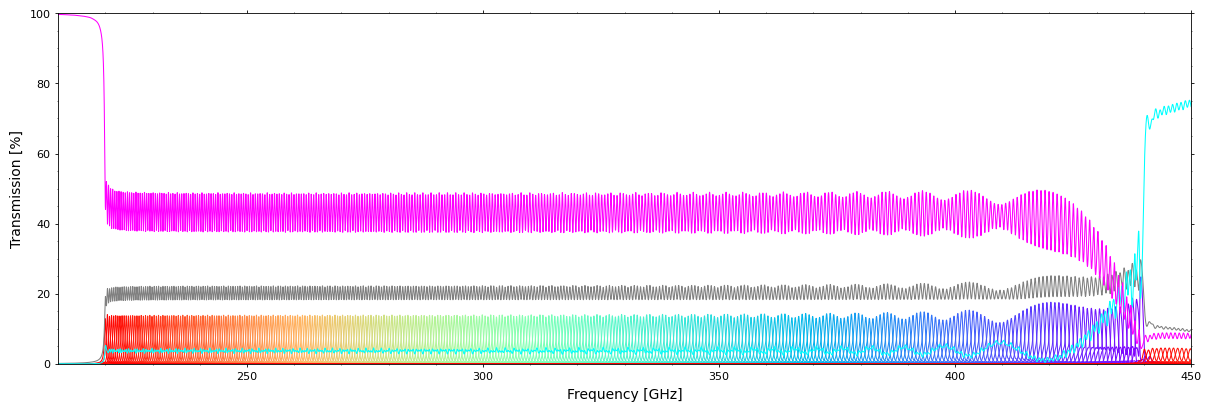

In [ ]:


################################################
fig, ax =plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(12,4),layout='constrained')

FB : Filterbank = R_sweep_data[ManifoldFilter][(500,500)]
print(FB.n_filters)
print(np.shape(FB.S31_absSq_list))
print(FB.S31_absSq_list[2])
S31_all = FB.S31_absSq_list

#ax
cmap = cm.get_cmap('rainbow').copy()
norm = mpl.colors.Normalize(vmin=0, vmax=np.shape(S31_all)[0])

for i,S31_absSq in enumerate(S31_all):
    ax.plot(f/1e9,100*S31_absSq,color=cmap(norm(i)))

sum_filters = np.sum(S31_all,axis=0)
ax.plot(f/1e9,100*sum_filters,label='sum filters',color="0.5")

envelope = np.array(FB.S31_absSq_list).max(axis=0)
# ax.plot(f/1e9,100*envelope["DirectionalFilter"],label='envelope',color=(0.,0.,0.))

ax.plot(f/1e9,100*FB.S11_absSq,label='S11',color=(0.,1.,1.))
ax.plot(f/1e9,100*FB.S21_absSq,label='S21',color=(1.,0.,1.))

ax.set_ylim(0,100)
ax.set_xlim(np.min(f)/1e9,np.max(f)/1e9)
ax.set_xlabel('Frequency [GHz]');
ax.set_ylabel('Transmission [%]');  # Add a y-label to the axes.
# plt.title("Realized Q-factors")  # Add a title to the axes.
# ax.legend();  # Add a legend.

# savestr = fig_path + "Filterbank_DirectionalFilter.svg"
# plt.savefig(fname=savestr)
# fig.canvas.manager.set_window_title(savestr)



In [ ]:
n = 1
for Filter in (ManifoldFilter,):
    for R_spacing in R_spacings:
        for R_filter_width in R_filter_widths:
            
            FB : Filterbank = R_sweep_data[Filter][(R_spacing,R_filter_width)]


            FB_data = np.block([np.array([FB.f/1e9]).T,np.array(FB.S31_absSq_list).T])

            masterid = "masterid"
            for filt_num in np.arange(FB.n_filters):
                masterid += f",{filt_num+100}"
            
            filter_kind = "kind" + ",filter" * FB.n_filters

            header = masterid + "\n" + filter_kind
    
            filename = f"./output/FB_sim_220-440GHz_R_spacing_{R_spacing}_R_filter_width_{R_filter_width}.csv"

            np.savetxt(filename,FB_data,delimiter=",",header=header)

            

---








# OLD CODE

In [ ]:
#### Manifold Filter
# Row = R_spacing
# Column = R_filter_width


In [ ]:

filterbank = dict()
envelope = dict()
Q_compensated_data = dict()
f0_compensated_data = dict()
inband_filter_eff = dict()
average_env_eff = dict()

######## Compensated ################
for Filter in Filters:
    filt_name = str(Filter.__name__)

    isolated_filter : BaseFilter = Filter(f0=350e9,Ql=Ql_compensation[filt_name],TransmissionLines=TransmissionLinesDict,sigma_f0=sigma_f0,sigma_Ql=sigma_Ql)

    isolated_filter.S(f2)

    # isolated_filter.plot()

    # savestr = fig_path + filt_name + "_isolated_filter.pdf"
    # plt.savefig(fname=savestr)
    # fig = plt.gcf()
    # fig.canvas.manager.set_window_title(savestr)
    # plt.close()

    filterbank[filt_name] = Filterbank(
        FilterClass=Filter,
        TransmissionLines=TransmissionLinesDict,
        f0_min=f0_min,
        f0_max=f0_max,
        Ql=Ql_compensation[filt_name],
        sigma_f0=sigma_f0,
        sigma_Ql=sigma_Ql
    )

    filterbank[filt_name].S(f)

    # filterbank[filt_name].plot()

    # savestr = fig_path + filt_name + "_filterbank.pdf"
    # plt.savefig(fname=savestr)
    # fig = plt.gcf()
    # fig.canvas.manager.set_window_title(savestr)

    f0_compensated_data[filt_name],Q_compensated_data[filt_name],inband_filter_eff[filt_name],_ = filterbank[filt_name].realized_parameters()
    average_env_eff[filt_name],_ = filterbank_analysis(Filterbank=filterbank[filt_name],f0_realized=f0_compensated_data[filt_name],Ql_realized=Q_compensated_data[filt_name])
    

    plt.close()


In [ ]:

fig, (ax1, ax2) =plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(5.5,2.5),layout='constrained')

for Filter in Filters:
    filt_name = str(Filter.__name__)
    ax1.scatter(f0_data[filt_name]/1e9,Q_data[filt_name],label=f"{filt_name}",color=Filtertype_color_dict[filt_name])
    ax2.scatter(f0_compensated_data[filt_name]/1e9,Q_compensated_data[filt_name],label=f"{filt_name}",color=Filtertype_color_dict[filt_name])


ax1.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax2.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax1.set_ylabel('Q-factor')  # Add a y-label to the axes.
ax1.set_title("Uncompensated Q-factors")  # Add a title to the axes.
ax1.legend();  # Add a legend.
ax2.set_title("Compensated Q-factors")  # Add a title to the axes.
# plt.ylim(-30,0)
# plt.xlim(np.min(f)/1e9,np.max(f)/1e9)

savestr = fig_path + "Realized_Q-factors.svg"
plt.savefig(fname=savestr)
fig.canvas.manager.set_window_title(savestr)


###############################################
fig, ax =plt.subplots(nrows=1,ncols=1,figsize=(2.5,2.5),layout='constrained')

for Filter in Filters:
    filt_name = str(Filter.__name__)
    ax.scatter(f0_compensated_data[filt_name]/1e9,inband_filter_eff[filt_name],label=f"{filt_name}",color=Filtertype_color_dict[filt_name])
    ax.plot(f0_compensated_data[filt_name]/1e9, np.mean(inband_filter_eff[filt_name])*np.ones(len(f0_compensated_data[filt_name])),color=Filtertype_color_dict[filt_name])
    ax.plot(f0_compensated_data[filt_name]/1e9, average_env_eff[filt_name]*np.ones(len(f0_compensated_data[filt_name])),color=Filtertype_color_dict[filt_name],linestyle=":")    
    



ax.set_xlabel('frequency [GHz]')  # Add an x-label to the axes.
ax.set_ylabel('efficiency')  # Add a y-label to the axes.
ax.set_title("In-band filter efficiency")  # Add a title to the axes.
# plt.ylim(-30,0)
# plt.xlim(np.min(f)/1e9,np.max(f)/1e9)

savestr = fig_path + "In-band_filter_efficiency.svg"
plt.savefig(fname=savestr)
fig.canvas.manager.set_window_title(savestr)




################################################
fig, ax =plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(6,1.5),layout='constrained')

S31_all = filterbank["DirectionalFilter"].S31_absSq_list

#ax
cmap = cm.get_cmap('rainbow').copy()
norm = mpl.colors.Normalize(vmin=0, vmax=np.shape(S31_all)[0])

for i,S31_absSq in enumerate(S31_all):
    ax.plot(f/1e9,100*S31_absSq,color=cmap(norm(i)))

sum_filters = np.sum(S31_all,axis=0)
ax.plot(f/1e9,100*sum_filters,label='sum filters',color="0.5")

envelope["DirectionalFilter"] = np.array(filterbank['DirectionalFilter'].S31_absSq_list).max(axis=0)
# ax.plot(f/1e9,100*envelope["DirectionalFilter"],label='envelope',color=(0.,0.,0.))

ax.plot(f/1e9,100*filterbank["DirectionalFilter"].S11_absSq,label='S11',color=(0.,1.,1.))
ax.plot(f/1e9,100*filterbank["DirectionalFilter"].S21_absSq,label='S21',color=(1.,0.,1.))

ax.set_ylim(0,100)
ax.set_xlim(np.min(f)/1e9,np.max(f)/1e9)
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Transmission [%]')  # Add a y-label to the axes.
# plt.title("Realized Q-factors")  # Add a title to the axes.
# ax.legend();  # Add a legend.

savestr = fig_path + "Filterbank_DirectionalFilter.svg"
plt.savefig(fname=savestr)
fig.canvas.manager.set_window_title(savestr)




#####################################
fig, ax =plt.subplots(nrows=1,ncols=1,sharex=True,figsize=(6,1.5),layout='constrained')

S31_all = filterbank["ManifoldFilter"].S31_absSq_list

#ax
cmap = cm.get_cmap('rainbow').copy()
norm = mpl.colors.Normalize(vmin=0, vmax=np.shape(S31_all)[0])

for i,S31_absSq in enumerate(S31_all):
    ax.plot(f/1e9,100*S31_absSq,color=cmap(norm(i)))

sum_filters = np.sum(S31_all,axis=0)
ax.plot(f/1e9,100*sum_filters,label='sum filters',color="0.5")

envelope["ManifoldFilter"] = np.array(filterbank['ManifoldFilter'].S31_absSq_list).max(axis=0)
# ax.plot(f/1e9,100*envelope["DirectionalFilter"],label='envelope',color=(0.,0.,0.))

ax.plot(f/1e9,100*filterbank["ManifoldFilter"].S11_absSq,label='S11',color=(0.,1.,1.))
ax.plot(f/1e9,100*filterbank["ManifoldFilter"].S21_absSq,label='S21',color=(1.,0.,1.))

ax.set_ylim(0,100)
ax.set_xlim(np.min(f)/1e9,np.max(f)/1e9)
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Transmission [%]')  # Add a y-label to the axes.
# plt.title("Realized Q-factors")  # Add a title to the axes.
# ax.legend();  # Add a legend.

savestr = fig_path + "Filterbank_ManifoldFilter.svg"
plt.savefig(fname=savestr)
fig.canvas.manager.set_window_title(savestr)

plt.show()